In [1]:
import numpy as np
from scipy.optimize import root_scalar
from matplotlib import pyplot as plt

from tqdm import tqdm

from gcv import SketchedSVDRidge, SketchedSolveRidge, EnsembleGCV, SketchedRidgeParams
from gcv.sketches import GaussianSketchFactory, OrthogonalSketchFactory, CountSketchFactory, SubsampledFourierSketchFactory, SketchSizeParams

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}')
plt.rcParams['figure.figsize'] = [6, 2]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['patch.linewidth'] = 0.7
plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
marker_cycle = ['o', 's', 'v', 'D', 'P', 'X', '*']

In [3]:
csf = CountSketchFactory(200)
csf(SketchSizeParams(156)).shape

(156, 200)

In [4]:
n, p = 140, 200
q = 156
sigma = 1
rng = np.random.default_rng(42)
n_ens = 1000
lamda = 0.1

X = rng.normal(size=(n, p))
beta = rng.normal(size=p) / np.sqrt(p)
y = X @ beta + rng.normal(scale=sigma, size=n)

params = SketchedRidgeParams(lamda, SketchSizeParams(q))
sketch_names = ['Gaussian', 'Orthogonal', 'CountSketch', 'SRDCT']
sketch_factories = [GaussianSketchFactory(p, rng=rng), OrthogonalSketchFactory(p, rng=rng), CountSketchFactory(p, rng=rng), SubsampledFourierSketchFactory(p, transform='dct', rng=rng)]

ensembles = []
for factory in tqdm(sketch_factories):
    ridges = [SketchedSolveRidge(X, y, factory) for _ in range(n_ens)]
    ens = EnsembleGCV(ridges)
    ens.div(params)
    ensembles.append(ens)


100%|██████████| 4/4 [00:14<00:00,  3.55s/it]


In [5]:
evs = np.linalg.eigvalsh(X.T @ X / n)

def estimate_mu(div):
    
    def f(mu):
        return np.sum(evs / (evs + mu)) - div
    
    return root_scalar(f, bracket=[0, (len(evs) / div - 1) * np.max(evs)]).root

gcv_errors = np.zeros((len(ensembles), n_ens))
ridge_gcv_errors = np.zeros(len(ensembles))

gen_errors = np.zeros((len(ensembles), n_ens))
ridge_gen_errors = np.zeros(len(ensembles))

for i, ensemble in enumerate(ensembles):
    
    mu = estimate_mu(ensemble.div(params))
    print(sketch_names[i], mu)
    ridge = EnsembleGCV([SketchedSolveRidge(X, y)])
    ridge_params = SketchedRidgeParams(mu, SketchSizeParams(p))

    ridge_gcv_errors[i] = ridge.eval_gcv(ridge_params)
    ridge_gen_errors[i] = ridge.eval_cond_gen(np.eye(p), beta, sigma, ridge_params)

    for K in range(1, n_ens + 1):
        ens = ensemble[:K]
        gcv_errors[i, K - 1] = ens.eval_gcv(params)
        gen_errors[i, K - 1] = ens.eval_cond_gen(np.eye(p), beta, sigma, params)

Gaussian 0.28258798720368217
Orthogonal 0.1568608275054502
CountSketch 0.2810406378905132
SRDCT 0.15674844288322842


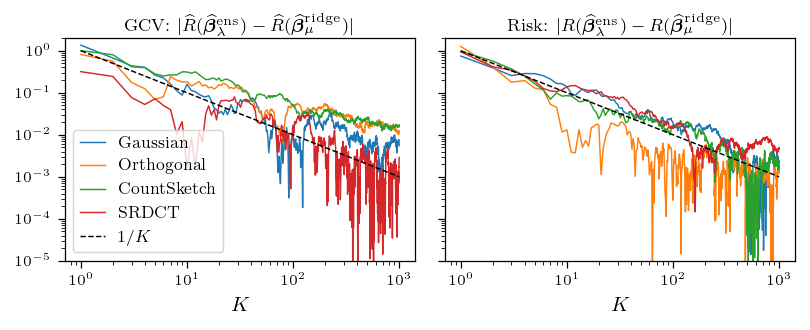

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(5.5, 2.3), dpi=150, sharey=True)

for i, sketch in enumerate(sketch_names):
    # plt.plot(np.arange(1, n_ens + 1), gcv_errors[i, :], label=sketch, color=color_cycle[i], marker=marker_cycle[i])
    axes[0].plot(np.arange(1, n_ens + 1), np.abs(gcv_errors[i, :] - ridge_gcv_errors[i]), label=sketch, color=color_cycle[i])
    axes[1].plot(np.arange(1, n_ens + 1), np.abs(gen_errors[i, :] - ridge_gen_errors[i]), label=sketch, color=color_cycle[i])
    # plt.plot([1, n_ens], ridge_gcv_errors[i] * np.ones(2), color=color_cycle[i], linestyle='--')

axes[0].plot(np.arange(1, n_ens + 1), 1 / np.arange(1, n_ens + 1), color='k', linestyle='--', label=r'$1/K$')
axes[1].plot(np.arange(1, n_ens + 1), 1 / np.arange(1, n_ens + 1), color='k', linestyle='--', label=r'$1/K$')

axes[0].set_title(r'GCV: $|\widehat{R}(\widehat{\bm \beta}^\mathrm{ens}_\lambda) - \widehat{R}(\widehat{\bm \beta}^\mathrm{ridge}_\mu)|$')
axes[0].set_xlabel(r'$K$')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_ylim(1e-5, 2)
axes[0].set_xscale('log')

axes[1].set_title(r'Risk: $|R(\widehat{\bm \beta}^\mathrm{ens}_\lambda) - R(\widehat{\bm \beta}^\mathrm{ridge}_\mu)|$')
axes[1].set_xlabel(r'$K$')
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig('figures/ensemble_convergence.pdf', bbox_inches='tight')
plt.show()